In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/surely_not_sarcasm_data/'

Mounted at /content/drive


In [ ]:
!cp -r '$root/utils' .

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import nltk
import pickle
import keras
import string
import re

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS as sklear_stopwords
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from scipy.sparse import hstack

from utils.evaluation import plot_history, evaluate, show_errors

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# prepare data

In [ ]:
df = pd.read_csv(root+'data/train_balanced_partly_preprocessed.csv')
df.head()

,label,comment,parent_comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",deadass don't kill my buzz
4,0,I could use one of those tools.,Yep can confirm I saw the tool they use for th...


In [ ]:
def map_special_strings(column):
    token_encoding = {
            ':)': ' xxsmilingfacexx ',
            ':]': ' xxsmilingfacexx ',
            ':-)': ' xxsmilingfacexx ',
            ';)': ' xxwinksmilingfacexx ',
            ':(': ' xxsadfacexx ',
            ':-(': ' xxsadfacexx ',
            ';(': ' xxcryingsadfacexx ',
            ':|': ' xxblankfacexx ',
            ':o': ' xxsurprisedfacexx ',
            ':/': ' xxwryfacexx ',
            ':D': ' xxgrinfacexx ',
            ';D': ' xxwinkgrinfacexx ',
            ':P': ' xxtonguefacexx ',
            ':p': ' xxtongueface2xx ',
            ';p': ' xxtongueface2xx ',
            '<3': ' xxheartxx '
    }

    column = (column
        .str.replace(r'https?:\/\/\S+\b|www\.(\w+\.)+\S*', 'xxurlxx', regex=True)
        .str.replace(r'\bu/\w+', 'xxuserxx', regex=True)
    )

    for token, encoding in token_encoding.items():
        pattern = re.compile(r'{}+(?!\S)'.format(re.escape(token)))
        column = column.str.replace(pattern, fr' {encoding} ', regex=True)

    column = (column
        .str.replace(r'[-+]?[.\d]*[\d]+[:,.\d]*', ' xxnumberxx ', regex=True)
        .str.replace(r'\b([a-zA-Z]+?)(.)\2{2,}\b', r'\1\2 xxelongxx ', regex=True)
        .str.replace(r"(\b[^a-z0-9\W()<>'`\-]{2,}\b)", r'\1 xxallcapsxx ', regex=True)
    )

    return column

In [ ]:
df['comment'] = map_special_strings(df['comment'])
df['parent_comment'] = map_special_strings(df['parent_comment'])

In [ ]:
X = df[['comment', 'parent_comment']]
y = df['label'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=42)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((722210, 2), (200615, 2), (80246, 2))

In [ ]:
def sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [ ]:
def vectorize_data(data, max_features=10000):
    all_sw = list(sklear_stopwords) + stopwords.words('english')
    count_vectorizer = CountVectorizer(stop_words=all_sw, token_pattern=r'(?u)\b\w\w+\b|\!|\?|\.\.\.|\*|\"',
                                       ngram_range=(1,3), max_features=max_features)

    vec_data = {}
    vec_data['train'] = count_vectorizer.fit_transform(data[0])
    vec_data['val'] = count_vectorizer.transform(data[1])
    vec_data['test'] = count_vectorizer.transform(data[2])

    return count_vectorizer, vec_data

# no context

In [ ]:
count_vectorizer, vec_data = vectorize_data([X_train['comment'], X_val['comment'], X_test['comment']])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(vec_data['train']), y_train)).shuffle(100).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(vec_data['val']), y_val)).batch(128)

In [ ]:
model = Sequential([
    InputLayer(input_shape=(vec_data['train'].shape[1],)),
    Dense(100, activation='relu', kernel_initializer='he_normal', kernel_regularizer=L1L2(l1=3e-6, l2=3e-6)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_13/dense_40/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_13/dense_40/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_13/dense_40/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


5643/5643 [==============================] - 34s 6ms/step - loss: 0.6587 - bc: 0.6094 - accuracy: 0.6670 - val_loss: 0.6612 - val_bc: 0.6006 - val_accuracy: 0.6795
Epoch 2/50
5643/5643 [==============================] - 32s 6ms/step - loss: 0.6592 - bc: 0.5959 - accuracy: 0.6781 - val_loss: 0.6612 - val_bc: 0.5970 - val_accuracy: 0.6810
Epoch 3/50
5643/5643 [==============================] - 33s 6ms/step - loss: 0.6568 - bc: 0.5929 - accuracy: 0.6812 - val_loss: 0.6593 - val_bc: 0.5955 - val_accuracy: 0.6816
Epoch 4/50
5643/5643 [==============================] - 34s 6ms/step - loss: 0.6537 - bc: 0.5906 - accuracy: 0.6833 - val_loss: 0.6572 - val_bc: 0.5943 - val_accuracy: 0.6834
Epoch 5/50
5643/5643 [==============================] - 33s 6ms/step - loss: 0.6515 - bc: 0.5892 - accuracy: 0.6850 - val_loss: 0.6577 - val_bc: 0.5949 - val_accuracy: 0.6848
Epoch 6/50
5643/5643 [==============================] - 34s 6ms/step - loss: 0.6498 - bc: 0.5877 - accuracy: 0.6864 - val_loss: 0.6547 -

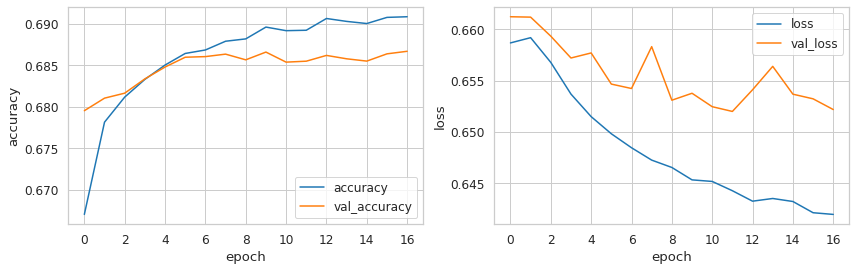

In [ ]:
plot_history(fit)

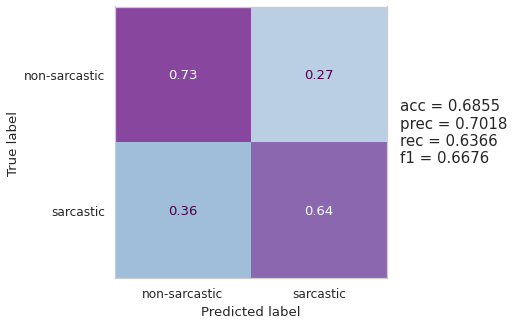

In [ ]:
evaluate(model, sparse_tensor(vec_data['test']), y_test)

In [ ]:
show_errors(model, X_test['comment'].values, sparse_tensor(vec_data['test']), y_test)

False negatives:
---------------------------
No xxelongxx .
It's not lies, it's perception management
Nah. xxelongxx the sun hurts too much when I leave my mom's basement.
"sacred"
pencitraan

False positives:
---------------------------
yup and women in burkas are...?
You need component cables and it'll look much, much better.
FIX xxallcapsxx  THE xxallcapsxx  GODDAMN xxallcapsxx  SERVERS xxallcapsxx !
Awesome, I happen to live off of Parmer!
I would be checking for  xxnumberxx  right?


# univariate feature selection

In [ ]:
def univariate_fs(scorer, data_filename, scores_filename, k=4000):
    kbest = SelectKBest(scorer, k=k)

    X_train = kbest.fit_transform(vec_data['train'], y_train)
    X_val = kbest.transform(vec_data['val'])
    X_test = kbest.transform(vec_data['test'])

    data = {'X_train': X_train, 'X_val': X_test, 'X_test': X_test}

    with open(root+'univariate_fs/'+data_filename, 'wb') as file:
        pickle.dump(data, file)

    df_scores = pd.DataFrame({
        'feature': count_vectorizer.get_feature_names_out(),
        'score': kbest.scores_
    })
    
    df_scores = df_scores.sort_values('score', ascending=False, ignore_index=True)
    df_scores.to_csv(root+fr'univariate_fs/{scores_filename}.csv', index=False)

    return df_scores

## chi2

In [ ]:
chi2_scores = univariate_fs(chi2, 'chi2_data', 'chi2_scores')

In [ ]:
chi2_scores.head(20)

,feature,score
0,!,13109.189087
1,yeah,9864.965553
2,obviously,4832.820834
3,totally,3825.902607
4,clearly,3066.856484
5,... ... ...,3041.075818
6,xxallcapsxx xxallcapsxx,2917.203841
7,... ...,2646.440154
8,xxnumberxx,2303.145213
9,comcast,2279.049634


## anova f-value

In [ ]:
f_scores = univariate_fs(f_classif, 'f_data', 'f_scores')

In [ ]:
f_scores.head(20)

,feature,score
0,!,14233.905102
1,yeah,10358.177405
2,obviously,4877.437219
3,totally,3796.895773
4,clearly,3068.594229
5,racist,1802.248379
6,right,1595.074095
7,yes,1592.042132
8,wow,1545.976858
9,right ?,1486.236132


# context

In [ ]:
_, vec_data = vectorize_data([X_train['comment'], X_val['comment'], X_test['comment']])
_, vec_data_par = vectorize_data([X_train['parent_comment'], X_val['parent_comment'], X_test['parent_comment']])

In [ ]:
X_train_vec = hstack([vec_data['train'], vec_data_par['train']])
X_val_vec = hstack([vec_data['val'], vec_data_par['val']])
X_test_vec = hstack([vec_data['test'], vec_data_par['test']])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(X_train_vec), y_train)).shuffle(100).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(X_val_vec), y_val)).batch(128)

In [ ]:
model = Sequential([
    InputLayer(input_shape=(X_train_vec.shape[1],)),
    Dense(100, activation='relu', kernel_initializer='he_normal', kernel_regularizer=L1L2(l1=5e-6, l2=5e-6)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_14/dense_42/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_14/dense_42/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_14/dense_42/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


5643/5643 [==============================] - 35s 6ms/step - loss: 0.7291 - bc: 0.6172 - accuracy: 0.6602 - val_loss: 0.7272 - val_bc: 0.6072 - val_accuracy: 0.6739
Epoch 2/50
5643/5643 [==============================] - 34s 6ms/step - loss: 0.7202 - bc: 0.6020 - accuracy: 0.6718 - val_loss: 0.7159 - val_bc: 0.6023 - val_accuracy: 0.6777
Epoch 3/50
5643/5643 [==============================] - 34s 6ms/step - loss: 0.7107 - bc: 0.5987 - accuracy: 0.6750 - val_loss: 0.7034 - val_bc: 0.5973 - val_accuracy: 0.6803
Epoch 4/50
5643/5643 [==============================] - 34s 6ms/step - loss: 0.7029 - bc: 0.5968 - accuracy: 0.6774 - val_loss: 0.7023 - val_bc: 0.5993 - val_accuracy: 0.6804
Epoch 5/50
5643/5643 [==============================] - 34s 6ms/step - loss: 0.6974 - bc: 0.5948 - accuracy: 0.6792 - val_loss: 0.7031 - val_bc: 0.6019 - val_accuracy: 0.6819
Epoch 6/50
5643/5643 [==============================] - 34s 6ms/step - loss: 0.6945 - bc: 0.5940 - accuracy: 0.6803 - val_loss: 0.7010 -

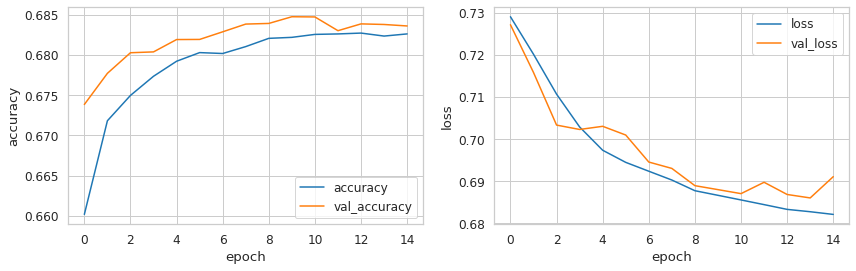

In [ ]:
plot_history(fit)

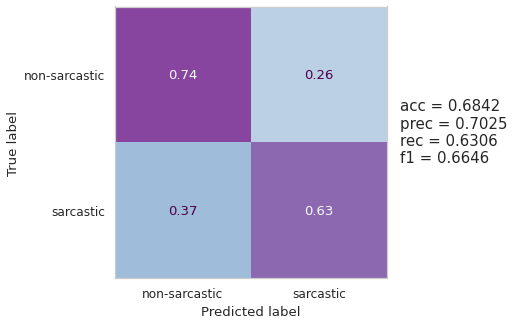

In [ ]:
evaluate(model, sparse_tensor(X_test_vec), y_test)

In [ ]:
show_errors(model, X_test['comment'].values, sparse_tensor(X_test_vec), y_test,
            X_parents=X_test['parent_comment'].values)

False negatives:
---------------------------
parent: One day, possibly. Sadly, not in our lifetime.
comment: just kill everyone and thus no more hate

parent: I dont know i think cam might get sentenced to LWOP xxallcapsxx 
comment: ^

parent: He gets sick on Lucy and not on a random dragon? What happened to I don't get sick on family and everyone in Fairy Tail is family?
comment: well Lucy is a Tool

parent: Hooooly cow. I see the reporters still couldn't describe it as anything other than 'gunned down.'
comment: Why couldn't they have asked the murderer nicely to please put the weapon down and act nice?

parent: Play on SG xxallcapsxx  servers  xxelongxx xxgrinfacexx  
comment: too bad i cant find any SG xxallcapsxx  xxnumberxx  only servers


False positives:
---------------------------
parent: Hearing about all these battles and politics in EVE xxallcapsxx  makes me think of Ready Player One for some reason. xxelongxx anyone else?
comment: I loved that book!

parent: I'm with you, 

In [ ]:
train_data = {'comment': sparse_tensor(vec_data['train']), 'parent': sparse_tensor(vec_data_par['train'])}
val_data = {'comment': sparse_tensor(vec_data['val']), 'parent': sparse_tensor(vec_data_par['val'])}
test_data = {'comment': sparse_tensor(vec_data['test']), 'parent': sparse_tensor(vec_data_par['test'])}

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, y_train)).shuffle(100).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, y_val)).batch(128)

In [ ]:
comment_input =  Input(shape=(vec_data['train'].shape[1],), name='comment')
parent_input = Input(shape=(vec_data_par['train'].shape[1],), name='parent')

com = Dense(100, activation='relu', kernel_initializer='he_normal',
            kernel_regularizer=L1L2(l1=5e-6, l2=5e-6))(comment_input)
com = BatchNormalization()(com)

par = Dense(100, activation='relu', kernel_initializer='he_normal',
            kernel_regularizer=L1L2(l1=5e-6, l2=5e-6))(parent_input)
par = BatchNormalization()(par)

x = Concatenate()([com, par])
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/dense_44/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/dense_44/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/dense_44/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/dense_45/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/dense_45/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dty

5643/5643 [==============================] - 47s 8ms/step - loss: 0.7173 - bc: 0.6080 - accuracy: 0.6689 - val_loss: 0.7120 - val_bc: 0.5974 - val_accuracy: 0.6817
Epoch 2/50
5643/5643 [==============================] - 46s 8ms/step - loss: 0.7075 - bc: 0.5945 - accuracy: 0.6794 - val_loss: 0.7017 - val_bc: 0.5943 - val_accuracy: 0.6854
Epoch 3/50
5643/5643 [==============================] - 45s 8ms/step - loss: 0.6951 - bc: 0.5916 - accuracy: 0.6818 - val_loss: 0.6937 - val_bc: 0.5922 - val_accuracy: 0.6860
Epoch 4/50
5643/5643 [==============================] - 46s 8ms/step - loss: 0.6881 - bc: 0.5897 - accuracy: 0.6837 - val_loss: 0.6874 - val_bc: 0.5920 - val_accuracy: 0.6864
Epoch 5/50
5643/5643 [==============================] - 46s 8ms/step - loss: 0.6827 - bc: 0.5885 - accuracy: 0.6850 - val_loss: 0.6820 - val_bc: 0.5892 - val_accuracy: 0.6883
Epoch 6/50
5643/5643 [==============================] - 45s 8ms/step - loss: 0.6778 - bc: 0.5874 - accuracy: 0.6867 - val_loss: 0.6799 -

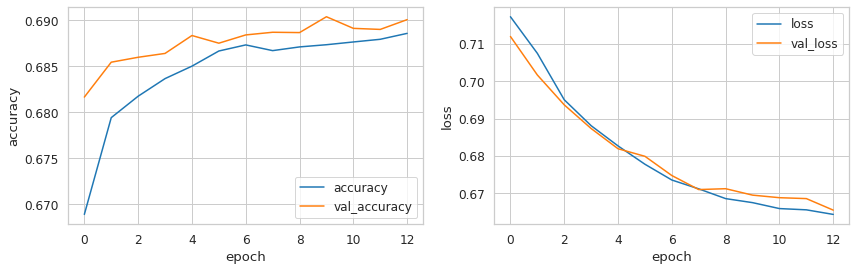

In [ ]:
plot_history(fit)

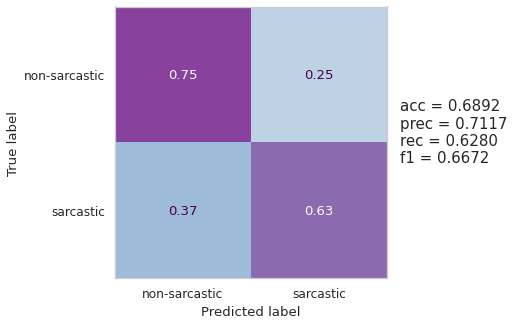

In [ ]:
evaluate(model, test_data, y_test)